In [ ]:
import numpy as np
import pandas as pd

In [ ]:
! pip install hierarchicalforecast

In [ ]:
! pip install datasetsforecast

In [ ]:
from datasetsforecast.hierarchical import HierarchicalData
from hierarchicalforecast.utils import aggregate

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load data

In [ ]:
Y_df, S_df, tags = HierarchicalData.load('./data', 'TourismLarge')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

100%|██████████| 1.30M/1.30M [00:00<00:00, 50.7MiB/s]
100%|██████████| 335k/335k [00:00<00:00, 11.5MiB/s]
100%|██████████| 968k/968k [00:00<00:00, 60.4MiB/s]


In [ ]:
Y_df.shape

(126540, 3)

In [ ]:
Y_df.head()

,unique_id,ds,y
0,TotalAll,1998-01-01,45151.071280
1,TotalAll,1998-02-01,17294.699551
2,TotalAll,1998-03-01,20725.114184
3,TotalAll,1998-04-01,25388.612353
4,TotalAll,1998-05-01,20330.035211


In [ ]:
Y_df.unique_id.nunique()

555

In [ ]:
S_df.head()

,AAAHol,AAAVis,AAABus,AAAOth,AABHol,AABVis,AABBus,AABOth,ABAHol,ABAVis,...,GBBBus,GBBOth,GBCHol,GBCVis,GBCBus,GBCOth,GBDHol,GBDVis,GBDBus,GBDOth
TotalAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
AAll,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DAll,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
Y_df.unique_id.value_counts()

,count
unique_id,
GBDOth,228
TotalAll,228
AAll,228
BAll,228
CAll,228
...,...
BBAll,228
BAAll,228
AFAll,228


In [ ]:
Y_df.ds.min(), Y_df.ds.max()

(Timestamp('1998-01-01 00:00:00'), Timestamp('2016-12-01 00:00:00'))

In [ ]:
Y_test_df = Y_df.groupby('unique_id').tail(12)
Y_train_df = Y_df.drop(Y_test_df.index)

In [ ]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [ ]:
Y_train_df.groupby('unique_id').size()

,0
unique_id,
AAAAll,216
AAABus,216
AAAHol,216
AAAOth,216
AAAVis,216
...,...
TotalAll,216
TotalBus,216
TotalHol,216


<Axes: xlabel='ds'>

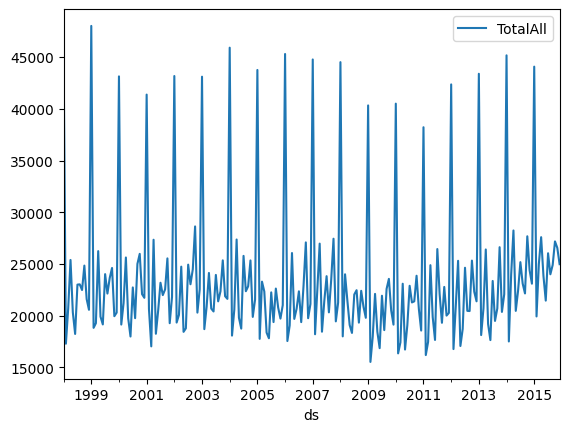

In [ ]:
Y_train_df\
    .query("unique_id == 'TotalAll'")\
    .set_index('ds')\
    .rename(columns={'y': 'TotalAll'})\
    .plot()

In [ ]:
short_tags = tags['Country/Purpose']

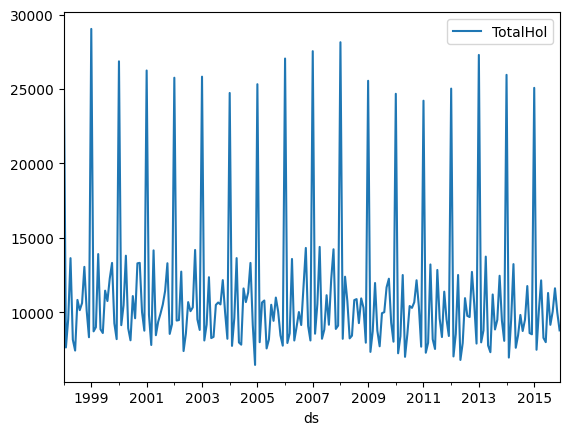

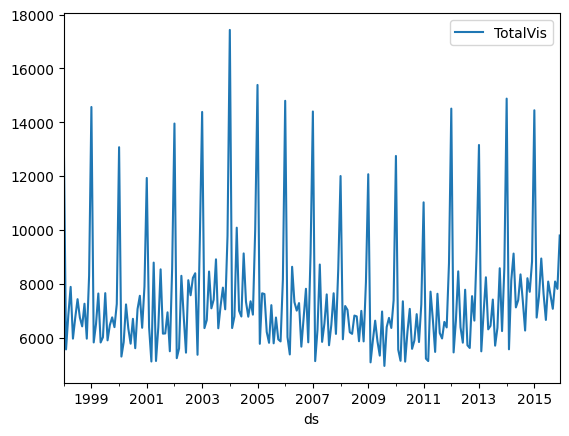

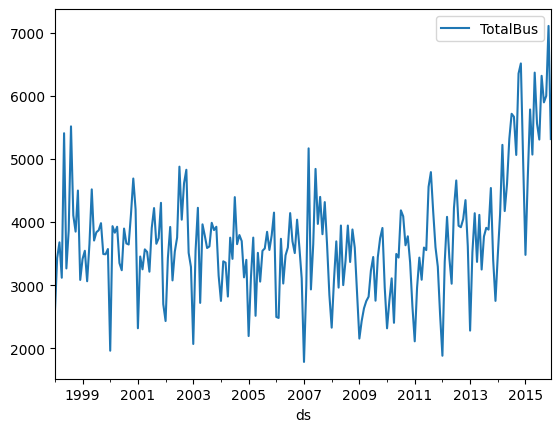

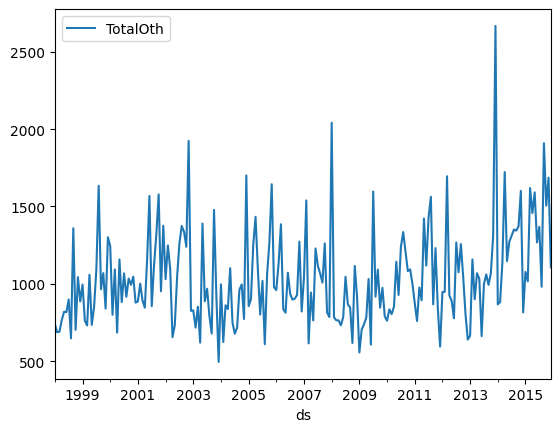

In [ ]:
for col in short_tags:
    Y_train_df\
        .query("unique_id == @col")\
        .set_index('ds')\
        .rename(columns={'y': col})\
        .plot()

# Base forecasts

In [ ]:
! pip install statsforecast

In [ ]:
from statsforecast.core import StatsForecast
from statsforecast.models import ETS

In [ ]:
fcst = StatsForecast(df=Y_train_df,
                     models=[ETS(season_length=12, model='ZZA')],
                     freq='MS', n_jobs=-1)
Y_hat_df = fcst.forecast(h=12, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

/usr/local/lib/python3.10/dist-packages/statsforecast/models.py:880: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:551: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to 

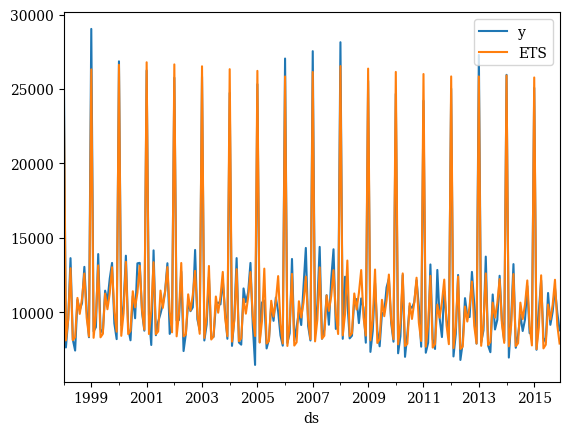

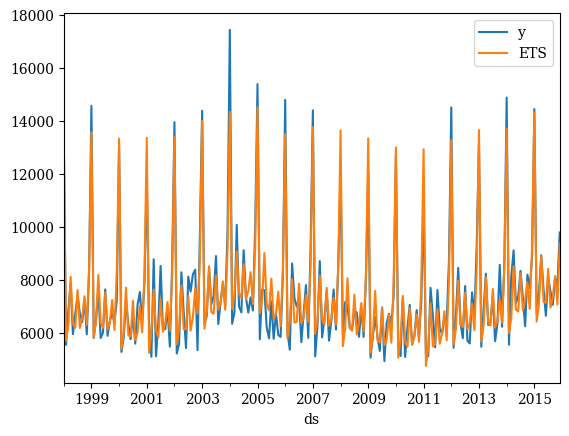

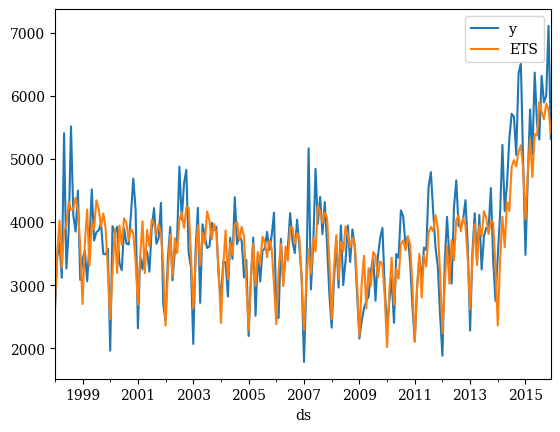

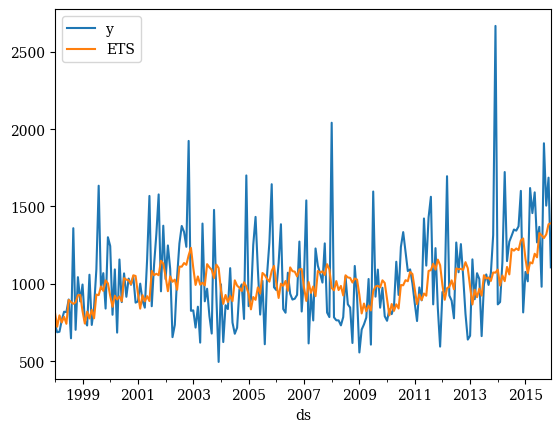

In [ ]:
for col in short_tags:
    Y_fitted_df.query("unique_id == @col").set_index('ds').plot()

# Reconcile forecasts

In [ ]:
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, MiddleOut, MinTrace, TopDown

In [ ]:
reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df,
                          Y_df=Y_fitted_df,
                          S=S_df,
                          tags=tags)

In [ ]:
Y_rec_df.head()

,ds,ETS,ETS/BottomUp,ETS/MinTrace_method-mint_shrink,ETS/MinTrace_method-ols
unique_id,,,,,
TotalAll,2016-01-01,46300.039062,44156.773438,45725.268785,46196.058213
TotalAll,2016-02-01,21044.667969,19775.113281,20682.723723,20960.176868
TotalAll,2016-03-01,23715.886719,22627.925781,23443.766525,23660.080957
TotalAll,2016-04-01,28315.083984,26993.267578,27940.149558,28212.366746
TotalAll,2016-05-01,22385.337891,20980.003906,21937.054761,22275.164050


In [ ]:
Y_rec_df.shape

(6660, 5)

In [ ]:
Y_rec_df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'], how='inner')

In [ ]:
Y_rec_df.shape

(6660, 6)

In [ ]:
short_tags

array(['TotalHol', 'TotalVis', 'TotalBus', 'TotalOth'], dtype=object)

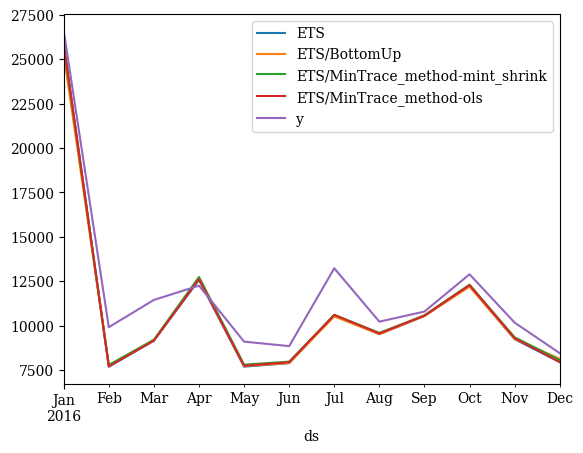

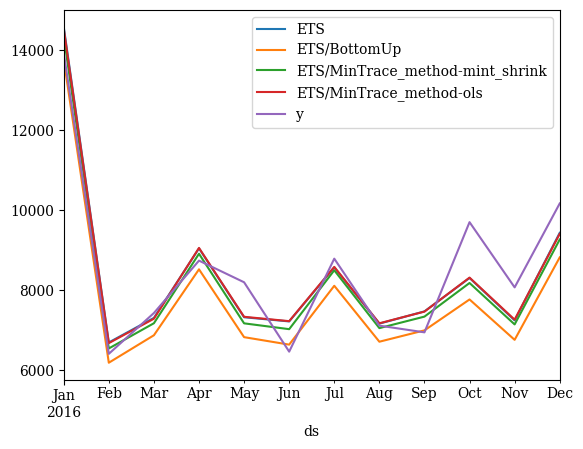

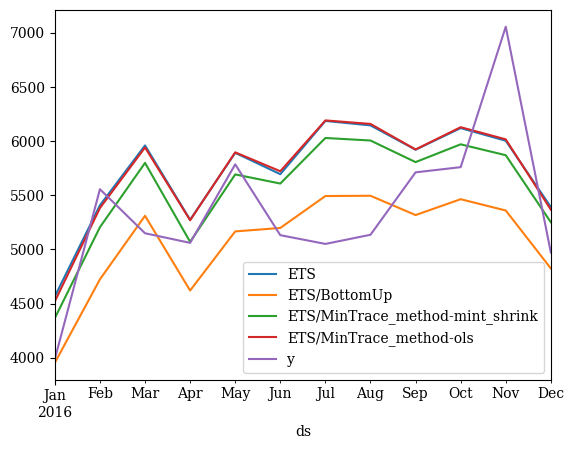

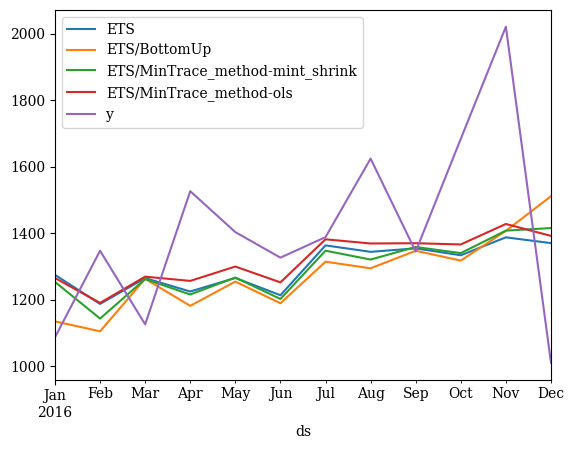

In [ ]:
for col in short_tags:
    Y_rec_df.query("unique_id == @col").set_index('ds').plot()

<Axes: xlabel='ds'>

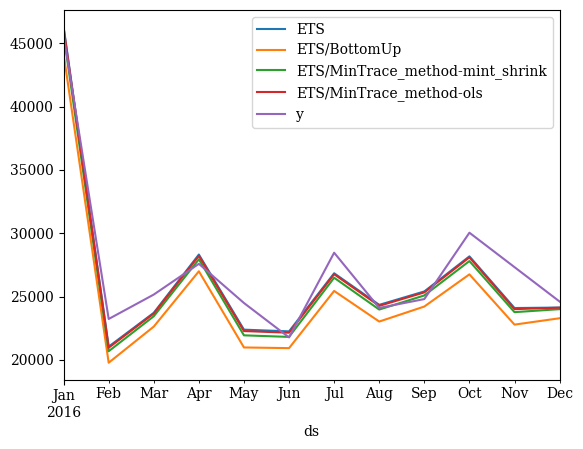

In [ ]:
Y_rec_df.query("unique_id == 'TotalAll'").set_index('ds').plot()

<Axes: xlabel='ds'>

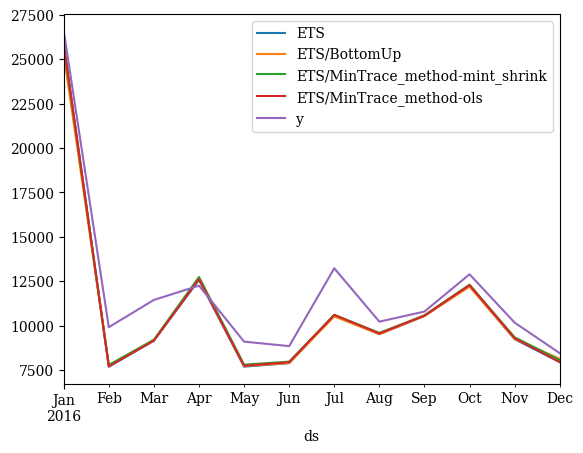

In [ ]:
Y_rec_df.query("unique_id == 'TotalHol'").set_index('ds').plot()

# Metrics & Evaluation

In [ ]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
def rmse(y, y_hat):
    return np.sqrt(np.mean((y - y_hat)**2))


def mape(y, y_hat):
    return np.mean(np.fabs(y - y_hat) / np.fabs(y))

In [ ]:
eval_tags = {}
eval_tags['Total'] = tags['Country']
eval_tags['Purpose'] = tags['Country/Purpose']
eval_tags['State'] = tags['Country/State']
eval_tags['Zone'] = tags['Country/State/Zone']
eval_tags['Bottom'] = tags['Country/State/Zone/Purpose']
# eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mean_absolute_percentage_error])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df)
evaluation = evaluation.drop('Overall')
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation = evaluation.applymap('{:.2f}'.format)

<ipython-input-40-0a6c8e81aba4>:13: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


In [ ]:
evaluation

Base  \
level   metric                                               
Total   rmse                                       1572.74   
        mean_absolute_percentage_error                0.05   
Purpose rmse                                        846.18   
        mean_absolute_percentage_error                0.11   
State   rmse                                        480.52   
        mean_absolute_percentage_error                0.13   
Zone    rmse                                        232.32   
        mean_absolute_percentage_error                0.21   
Bottom  rmse                                        105.22   
        mean_absolute_percentage_error  800082571358259.38   

                                                  BottomUp  \
level   metric                                               
Total   rmse                                       2543.11   
        mean_absolute_percentage_error                0.08   
Purpose rmse                                        912.11   
        mean_absolute_percentage_error                0.11   
State   rmse                                        589.97   
        mean_absolute_percentage_error                0.14   
Zone    rmse                                        248.26   
        mean_absolute_percentage_error                0.20   
Bottom  rmse                                        106.49   
        mean_absolute_percentage_error  776717882987659.88   

                                       MinTrace(mint_shrink)  \
level   metric                                                 
Total   rmse                                         1781.14   
        mean_absolute_percentage_error                  0.05   
Purpose rmse                                          822.66   
        mean_absolute_percentage_error                  0.10   
State   rmse                                          504.26   
        mean_absolute_percentage_error                  0.12   
Zone    rmse                                          228.08   
        mean_absolute_percentage_error                  0.21   
Bottom  rmse                                          102.89   
        mean_absolute_percentage_error    884255502198515.88   

                                              MinTrace(ols)  
level   metric                                               
Total   rmse                                        1616.36  
        mean_absolute_percentage_error                 0.05  
Purpose rmse                                         835.63  
        mean_absolute_percentage_error                 0.10  
State   rmse                                         482.77  
        mean_absolute_percentage_error                 0.12  
Zone    rmse                                         226.63  
        mean_absolute_percentage_error                 0.21  
Bottom  rmse                                         102.84  
        mean_absolute_percentage_error  1269979138019046.75

# Top Down

In [ ]:
Y_df_short, S_df_short, tags_short = HierarchicalData.load('./data', 'Traffic')
Y_df_short['ds'] = pd.to_datetime(Y_df_short['ds'])

In [ ]:
Y_df_short.head()

,unique_id,ds,y
0,Total,2008-01-01,1536.0182
1,Total,2008-01-02,1619.2435
2,Total,2008-01-03,1423.6574
3,Total,2008-01-04,1096.3325
4,Total,2008-01-05,974.5526


In [ ]:
S_df_short.head()

,Bottom1,Bottom2,Bottom3,Bottom4,Bottom5,Bottom6,Bottom7,Bottom8,Bottom9,Bottom10,...,Bottom191,Bottom192,Bottom193,Bottom194,Bottom195,Bottom196,Bottom197,Bottom198,Bottom199,Bottom200
Total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
y1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
y11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
y12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tags_short

{'Level1': array(['Total'], dtype=object),
 'Level2': array(['y1', 'y2'], dtype=object),
 'Level3': array(['y11', 'y12', 'y21', 'y22'], dtype=object),
 'Level4': array(['Bottom1', 'Bottom2', 'Bottom3', 'Bottom4', 'Bottom5', 'Bottom6',
        'Bottom7', 'Bottom8', 'Bottom9', 'Bottom10', 'Bottom11',
        'Bottom12', 'Bottom13', 'Bottom14', 'Bottom15', 'Bottom16',
        'Bottom17', 'Bottom18', 'Bottom19', 'Bottom20', 'Bottom21',
        'Bottom22', 'Bottom23', 'Bottom24', 'Bottom25', 'Bottom26',
        'Bottom27', 'Bottom28', 'Bottom29', 'Bottom30', 'Bottom31',
        'Bottom32', 'Bottom33', 'Bottom34', 'Bottom35', 'Bottom36',
        'Bottom37', 'Bottom38', 'Bottom39', 'Bottom40', 'Bottom41',
        'Bottom42', 'Bottom43', 'Bottom44', 'Bottom45', 'Bottom46',
        'Bottom47', 'Bottom48', 'Bottom49', 'Bottom50', 'Bottom51',
        'Bottom52', 'Bottom53', 'Bottom54', 'Bottom55', 'Bottom56',
        'Bottom57', 'Bottom58', 'Bottom59', 'Bottom60', 'Bottom61',
        'Bottom62', 

In [ ]:
Y_test_df = Y_df_short.groupby('unique_id').tail(5*7)
Y_train_df = Y_df_short.drop(Y_test_df.index)

In [ ]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

<Axes: xlabel='ds'>

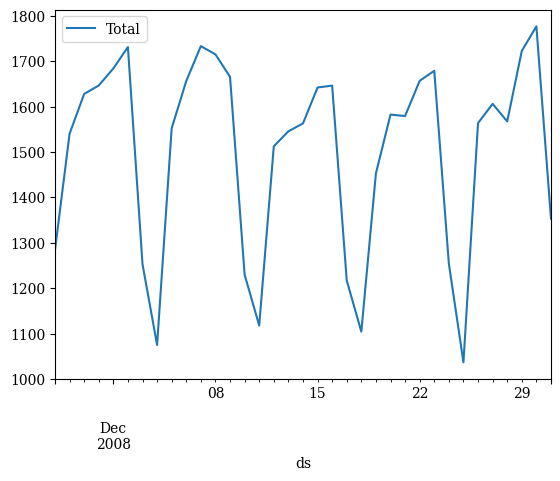

In [ ]:
Y_test_df.query("unique_id == 'Total'").set_index('ds').rename(columns={'y': 'Total'}).plot()

<Axes: xlabel='ds'>

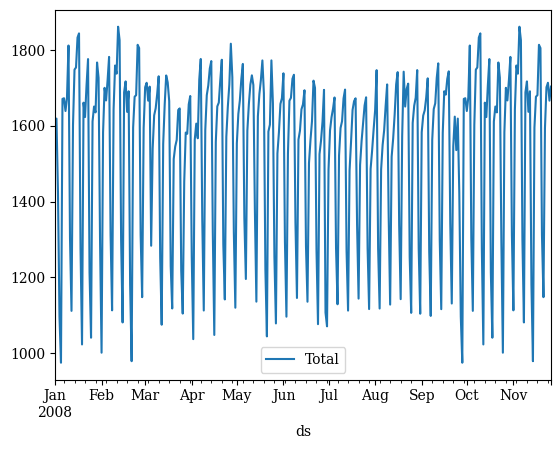

In [ ]:
Y_train_df.query("unique_id == 'Total'").set_index('ds').rename(columns={'y': 'Total'}).plot()

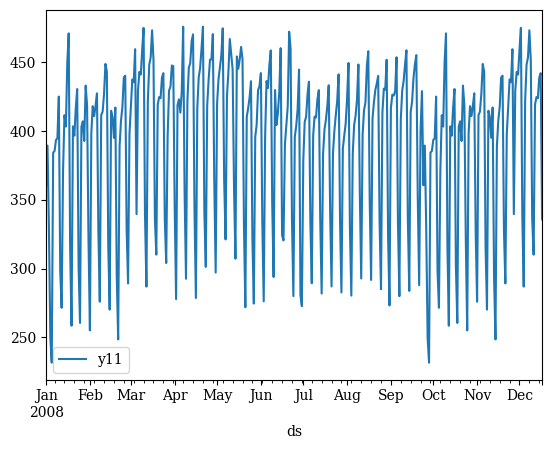

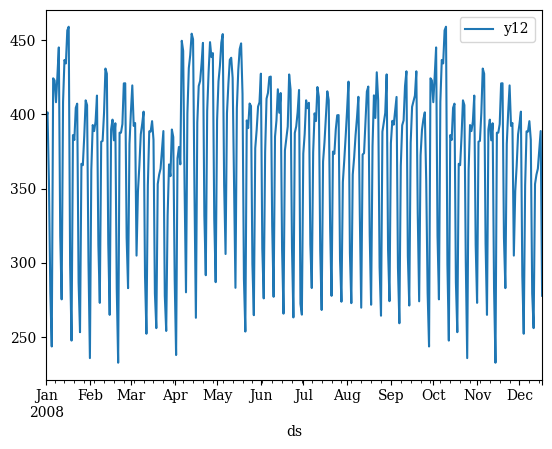

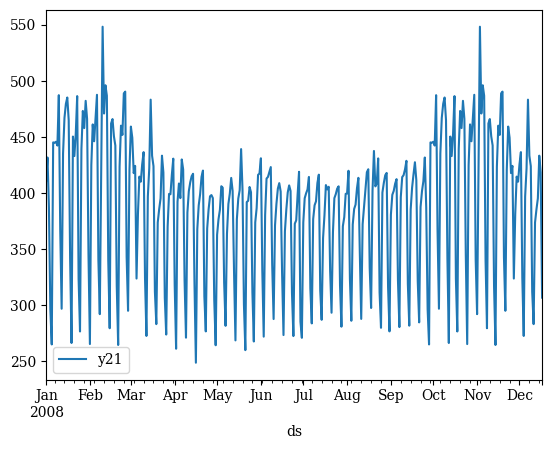

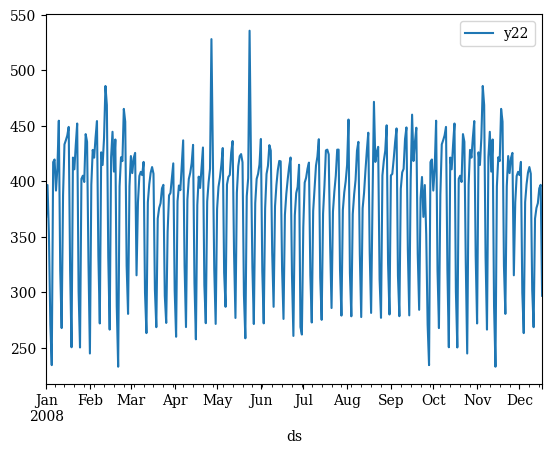

In [ ]:
short_tags = tags_short['Level3']
for col in short_tags:
    Y_train_df.query("unique_id == @col").set_index('ds').rename(columns={'y': col}).plot()

In [ ]:
fcst = StatsForecast(df=Y_train_df,
                     models=[ETS(season_length=7, model='ZZA')],
                     freq='D', n_jobs=-1)
Y_hat_df = fcst.forecast(h=5*7, fitted=True)
Y_fitted_df = fcst.forecast_fitted_values()

/usr/local/lib/python3.10/dist-packages/statsforecast/models.py:880: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:551: FutureWarning: Passing unique_id as the index is deprecated. Please provide it as a column instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to 

<Axes: xlabel='ds'>

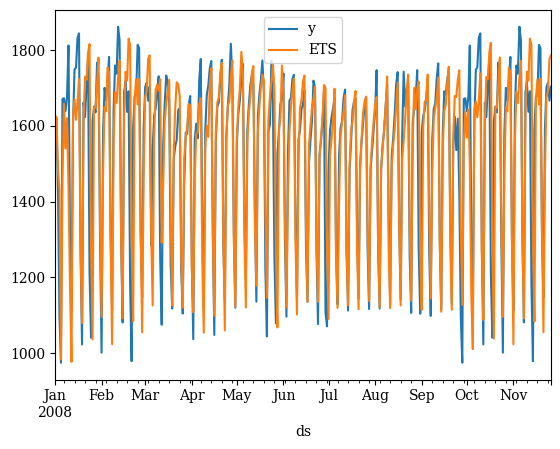

In [ ]:
Y_fitted_df.query("unique_id == 'Total'").set_index('ds').plot()

In [ ]:
reconcilers = [
    TopDown(method='forecast_proportions'),
    TopDown(method='average_proportions'),
    TopDown(method='proportion_averages'),
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df,
                          Y_df=Y_fitted_df,
                          S=S_df_short,
                          tags=tags_short)

In [ ]:
Y_rec_df.head()

,ds,ETS,ETS/TopDown_method-forecast_proportions,ETS/TopDown_method-average_proportions,ETS/TopDown_method-proportion_averages
unique_id,,,,,
Total,2008-11-27,1316.456543,1316.456543,1316.456545,1316.456580
Total,2008-11-28,1125.891357,1125.891357,1125.891359,1125.891389
Total,2008-11-29,1566.104370,1566.104370,1566.104372,1566.104414
Total,2008-11-30,1695.975342,1695.975342,1695.975344,1695.975390
Total,2008-12-01,1708.487061,1708.487061,1708.487063,1708.487109


In [ ]:
Y_rec_df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'], how='inner')

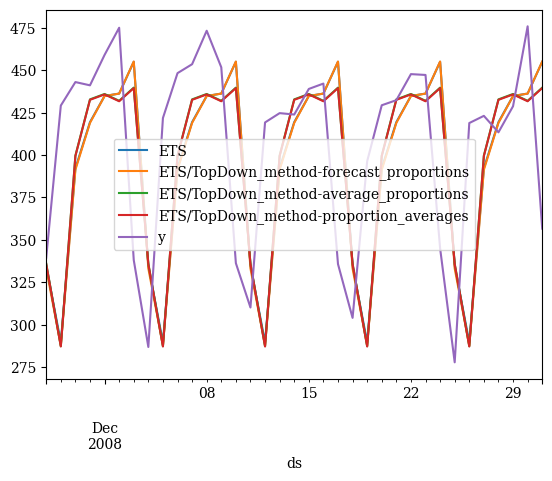

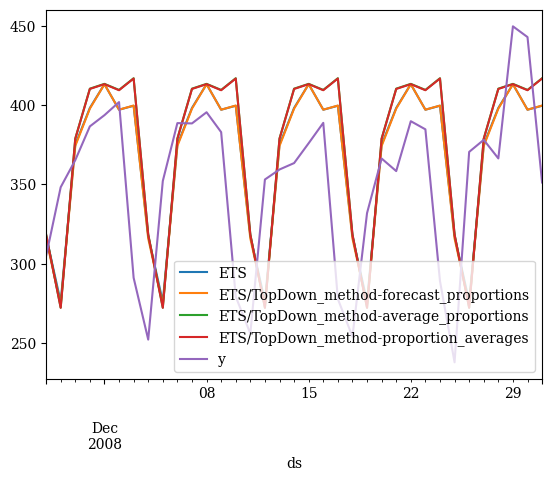

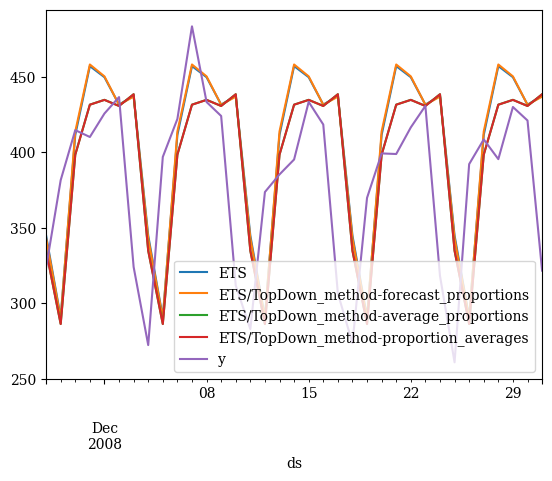

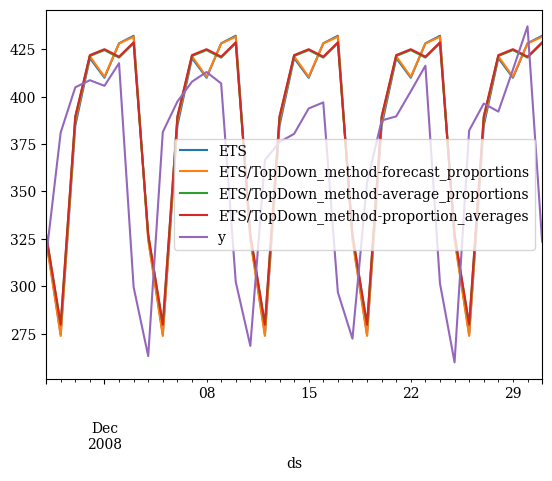

In [ ]:
for col in short_tags:
    Y_rec_df.query("unique_id == @col").set_index('ds').plot()

In [ ]:
eval_tags = {}
eval_tags['Total'] = tags_short['Level1']
eval_tags['Level2'] = tags_short['Level2']
eval_tags['Level3'] = tags_short['Level3']
eval_tags['Level4'] = tags_short['Level4']
# eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mean_absolute_percentage_error])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation = evaluation.applymap('{:.2f}'.format)

<ipython-input-55-c03d31e344be>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


In [ ]:
evaluation

ETS  \
level  metric                                  
Total  rmse                            62.23   
       mean_absolute_percentage_error   0.03   
Level2 rmse                            33.80   
       mean_absolute_percentage_error   0.03   
Level3 rmse                            20.51   
       mean_absolute_percentage_error   0.04   
Level4 rmse                             2.04   
       mean_absolute_percentage_error   0.15   

                                      ETS/TopDown_method-forecast_proportions  \
level  metric                                                                   
Total  rmse                                                             62.23   
       mean_absolute_percentage_error                                    0.03   
Level2 rmse                                                             33.74   
       mean_absolute_percentage_error                                    0.03   
Level3 rmse                                                             20.54   
       mean_absolute_percentage_error                                    0.04   
Level4 rmse                                                              2.01   
       mean_absolute_percentage_error                                    0.14   

                                      ETS/TopDown_method-average_proportions  \
level  metric                                                                  
Total  rmse                                                            62.23   
       mean_absolute_percentage_error                                   0.03   
Level2 rmse                                                            34.86   
       mean_absolute_percentage_error                                   0.03   
Level3 rmse                                                            21.25   
       mean_absolute_percentage_error                                   0.04   
Level4 rmse                                                             2.33   
       mean_absolute_percentage_error                                   0.25   

                                      ETS/TopDown_method-proportion_averages  
level  metric                                                                 
Total  rmse                                                            62.23  
       mean_absolute_percentage_error                                   0.03  
Level2 rmse                                                            34.98  
       mean_absolute_percentage_error                                   0.03  
Level3 rmse                                                            21.30  
       mean_absolute_percentage_error                                   0.04  
Level4 rmse                                                             2.33  
       mean_absolute_percentage_error                                   0.26

# Middle-Out

In [ ]:
reconcilers = [
    MiddleOut(middle_level='Level2', top_down_method='forecast_proportions'),
    MiddleOut(middle_level='Level3', top_down_method='forecast_proportions')
]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df,
                          Y_df=Y_fitted_df,
                          S=S_df_short,
                          tags=tags_short)

In [ ]:
Y_rec_df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'], how='inner')

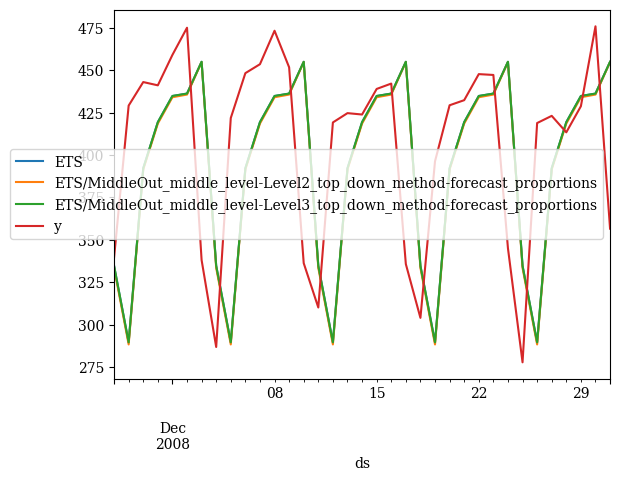

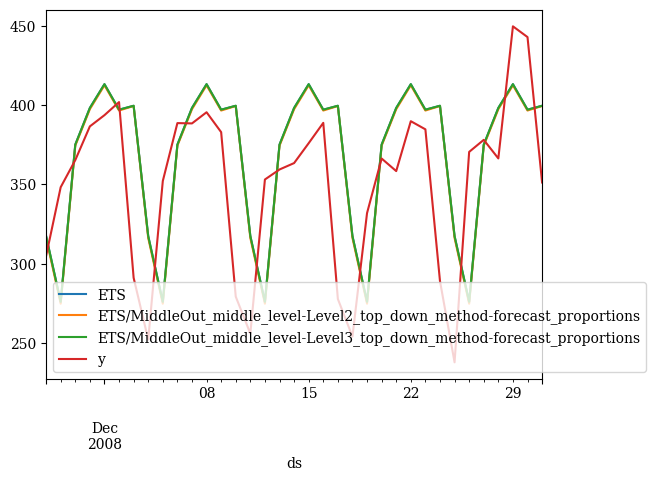

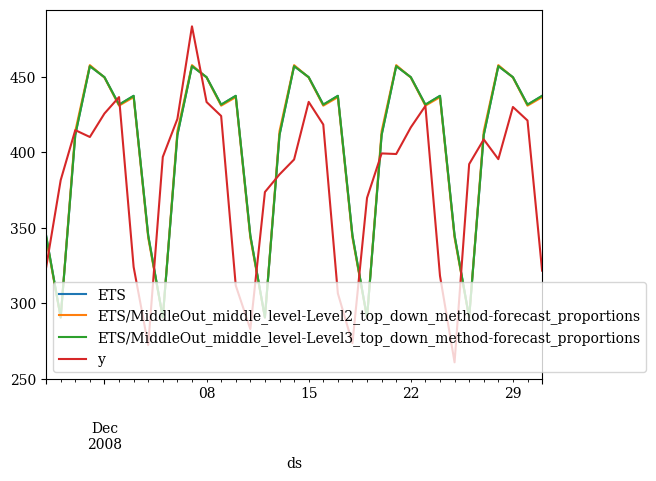

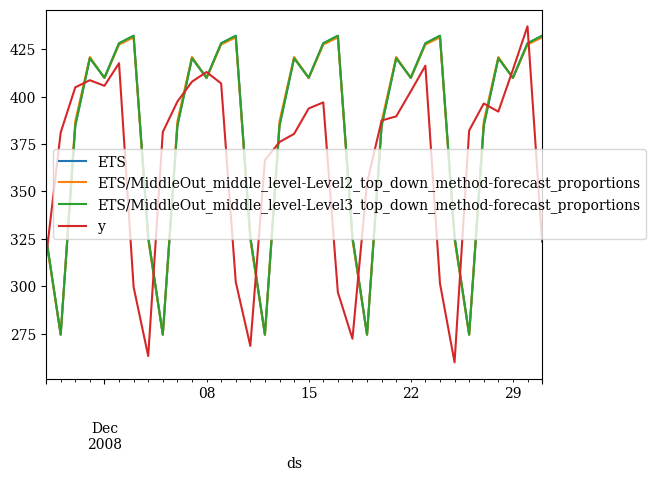

In [ ]:
for col in short_tags:
    Y_rec_df.query("unique_id == @col").set_index('ds').plot()

In [ ]:
eval_tags = {}
eval_tags['Total'] = tags_short['Level1']
eval_tags['Level2'] = tags_short['Level2']
eval_tags['Level3'] = tags_short['Level3']
eval_tags['Level4'] = tags_short['Level4']
# eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mean_absolute_percentage_error])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation = evaluation.applymap('{:.2f}'.format)

<ipython-input-69-c03d31e344be>:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


In [ ]:
evaluation

ETS  \
level  metric                                   
Total  rmse                            249.91   
       mean_absolute_percentage_error    0.13   
Level2 rmse                            126.18   
       mean_absolute_percentage_error    0.14   
Level3 rmse                             64.95   
       mean_absolute_percentage_error    0.14   
Level4 rmse                              3.06   
       mean_absolute_percentage_error    0.33   

                                      ETS/MiddleOut_middle_level-Level2_top_down_method-forecast_proportions  \
level  metric                                                                                                  
Total  rmse                                                                       249.03                       
       mean_absolute_percentage_error                                               0.13                       
Level2 rmse                                                                       126.18                       
       mean_absolute_percentage_error                                               0.14                       
Level3 rmse                                                                        64.85                       
       mean_absolute_percentage_error                                               0.14                       
Level4 rmse                                                                         2.94                       
       mean_absolute_percentage_error                                               0.31                       

                                      ETS/MiddleOut_middle_level-Level3_top_down_method-forecast_proportions  
level  metric                                                                                                 
Total  rmse                                                                       249.68                      
       mean_absolute_percentage_error                                               0.13                      
Level2 rmse                                                                       126.39                      
       mean_absolute_percentage_error                                               0.14                      
Level3 rmse                                                                        64.95                      
       mean_absolute_percentage_error                                               0.14                      
Level4 rmse                                                                         2.94                      
       mean_absolute_percentage_error                                               0.31

# Features

In [ ]:
def get_df(df_path='/content/monthly_car_sales.csv', date_col='Month'):
    df = pd.read_csv(df_path)
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [ ]:
df = get_df()

In [ ]:
df.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [ ]:
df.shape

(108, 1)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
df.head()

,Sales
Month,
1960-01-01,6550
1960-02-01,8728
1960-03-01,12026
1960-04-01,14395
1960-05-01,14587


In [ ]:
X = df.reset_index().index.values[:-30]
y = df.Sales.values[:-30]

In [ ]:
linreg = LinearRegression(n_jobs=-1)
lgbm = LGBMRegressor(n_estimators=10)

linreg.fit(X.reshape(-1, 1), y)
lgbm.fit(X.reshape(-1, 1), y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 1
[LightGBM] [Info] Start training from score 13669.730769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMRegressor(n_estimators=10)

<Axes: xlabel='Month'>

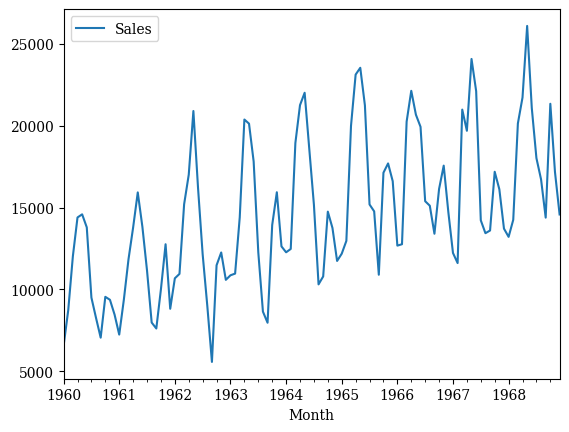

In [ ]:
df.plot()

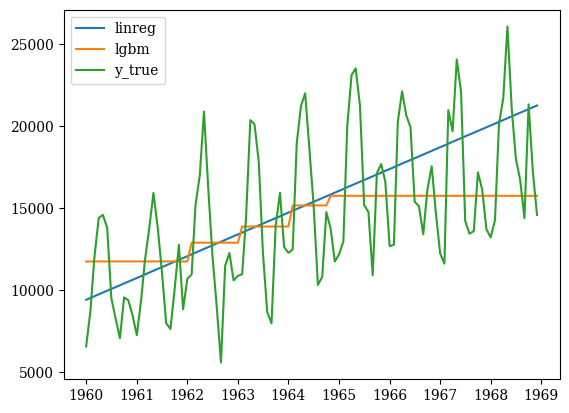

In [ ]:
plt.plot(df.index, linreg.predict(df.reset_index().index.values.reshape(-1, 1)), label='linreg');
plt.plot(df.index, lgbm.predict(df.reset_index().index.values.reshape(-1, 1)), label='lgbm');
plt.plot(df.index, df.Sales, label='y_true');
plt.legend();

## Lags

In [ ]:
df['lag_3'] = df.Sales.shift(3)
df['lag_4'] = df.Sales.shift(4)
df['lag_5'] = df.Sales.shift(5)
df[:10]

,Sales,lag_3,lag_4,lag_5
Month,,,,
1960-01-01,6550,NaN,NaN,NaN
1960-02-01,8728,NaN,NaN,NaN
1960-03-01,12026,NaN,NaN,NaN
1960-04-01,14395,6550.0,NaN,NaN
1960-05-01,14587,8728.0,6550.0,NaN
1960-06-01,13791,12026.0,8728.0,6550.0
1960-07-01,9498,14395.0,12026.0,8728.0
1960-08-01,8251,14587.0,14395.0,12026.0
1960-09-01,7049,13791.0,14587.0,14395.0


In [ ]:
X = df.drop(columns=['Sales']).reset_index().drop(columns=['Month']).reset_index().values[5:]
y = df.Sales.values[5:]

linreg = LinearRegression(n_jobs=-1)
lgbm = LGBMRegressor(n_estimators=10)

linreg.fit(X, y)
lgbm.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 144
[LightGBM] [Info] Number of data points in the train set: 103, number of used features: 4
[LightGBM] [Info] Start training from score 14757.145631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(n_estimators=10)

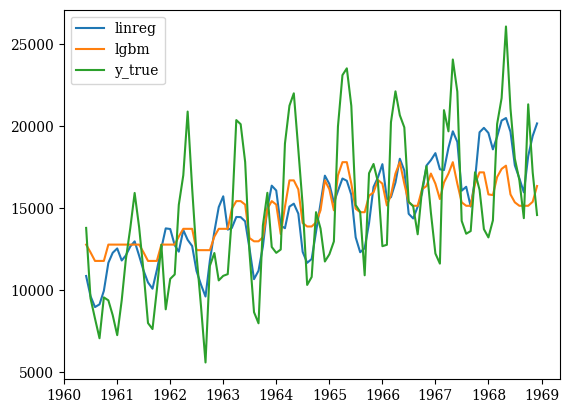

In [ ]:
plt.plot(df.index[5:], linreg.predict(X), label='linreg');
plt.plot(df.index[5:], lgbm.predict(X), label='lgbm');
plt.plot(df.index[5:], df.Sales[5:], label='y_true');
plt.legend();

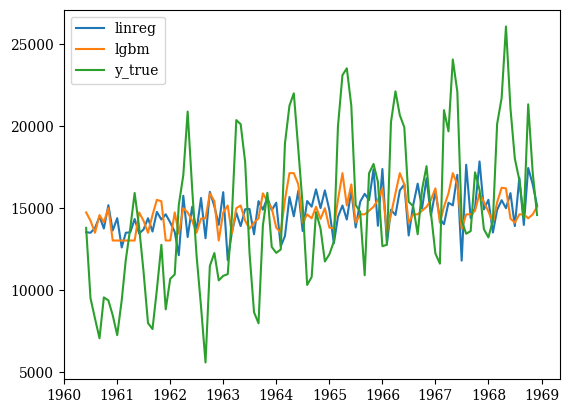

In [ ]:
plt.plot(df.index[5:], linreg.predict(X), label='linreg');
plt.plot(df.index[5:], lgbm.predict(X), label='lgbm');
plt.plot(df.index[5:], df.Sales[5:], label='y_true');
plt.legend();

In [ ]:
horizon = 12

def split_df(df, h=horizon):
    df_train, df_test = df[: len(df) - h], df[len(df) - h:]
    return df_train, df_test

In [ ]:
df_train, df_test = split_df(df)

In [ ]:
df_train.tail()

,Sales,lag_3,lag_4,lag_5
Month,,,,
1967-08-01,13434,24081.0,19692.0,20985.0
1967-09-01,13598,22114.0,24081.0,19692.0
1967-10-01,17187,14220.0,22114.0,24081.0
1967-11-01,16119,13434.0,14220.0,22114.0
1967-12-01,13713,13598.0,13434.0,14220.0


In [ ]:
df_test

,Sales,lag_3,lag_4,lag_5
Month,,,,
1968-01-01,13210,17187.0,13598.0,13434.0
1968-02-01,14251,16119.0,17187.0,13598.0
1968-03-01,20139,13713.0,16119.0,17187.0
1968-04-01,21725,13210.0,13713.0,16119.0
1968-05-01,26099,14251.0,13210.0,13713.0
1968-06-01,21084,20139.0,14251.0,13210.0
1968-07-01,18024,21725.0,20139.0,14251.0
1968-08-01,16722,26099.0,21725.0,20139.0
1968-09-01,14385,21084.0,26099.0,21725.0


есть ли лик?

в общем случае надо так $lag_{t-k}$, где $k >= horizon$

можно починить, например, так:

In [ ]:
df = get_df()
df['Sales'].iloc[-horizon:] = np.nan
df['lag_1'] = df.Sales.shift(1)
df['lag_4'] = df.Sales.shift(4)
df['lag_12'] = df.Sales.shift(12)
df_train, df_test = split_df(df)

In [ ]:
df_train.tail()

,Sales,lag_1,lag_4,lag_12
Month,,,,
1967-08-01,13434.0,14220.0,19692.0,15113.0
1967-09-01,13598.0,13434.0,24081.0,13401.0
1967-10-01,17187.0,13598.0,22114.0,16135.0
1967-11-01,16119.0,17187.0,14220.0,17562.0
1967-12-01,13713.0,16119.0,13434.0,14720.0


In [ ]:
df_test

,Sales,lag_1,lag_4,lag_12
Month,,,,
1968-01-01,NaN,13713.0,13598.0,12225.0
1968-02-01,NaN,NaN,17187.0,11608.0
1968-03-01,NaN,NaN,16119.0,20985.0
1968-04-01,NaN,NaN,13713.0,19692.0
1968-05-01,NaN,NaN,NaN,24081.0
1968-06-01,NaN,NaN,NaN,22114.0
1968-07-01,NaN,NaN,NaN,14220.0
1968-08-01,NaN,NaN,NaN,13434.0
1968-09-01,NaN,NaN,NaN,13598.0
